In [19]:
import torch
import torch.nn.functional as F

from pl_bolts.models.autoencoders import AE

class CIFAR10NoisyLightningAutoencoder(AE):
    def __init__(self, input_height=32):

        super().__init__(input_height=input_height)
        self.cls_model = CIFAR10Classifier.load_from_checkpoint("../lightning_logs/cifar10_classifier/checkpoints/epoch=49-step=35150.ckpt")
        self.cls_model.eval()

    def get_z(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.encoder(x)
        z = self.fc(feats)

        return z
    
    def get_x_hat(self, z: torch.Tensor) -> torch.Tensor:
        x_hat = self.decoder(z)

        return x_hat
    
    def forward(self, x):
        feats = self.encoder(x)
        z = self.fc(feats)
        z = z + torch.randn_like(z)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def step(self, batch, batch_idx):
        x, y = batch

        feats = self.encoder(x)
        z = self.fc(feats)
        x_hat = self.decoder(z)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")
        
        # classifier loss

        logits = self.cls_model(x)
        cls_loss = F.nll_loss(logits, y)

        loss = recon_loss + cls_loss

        return loss, {"loss": loss}

In [10]:
import sys

sys.path.append("..")

import pytorch_lightning as pl
from dataloader import load_cifar

model = CIFAR10NoisyLightningAutoencoder()
model = model.from_pretrained('cifar10-resnet18')

train_dataloader, valid_dataloader, test_dataloader = load_cifar(
    root="~/scratch/datasets/CIFAR10/", batch_size=128
)

trainer = pl.Trainer(max_epochs=200, accelerator="gpu", default_root_dir="..")
trainer.fit(model, train_dataloader, valid_dataloader)

/tmp/ipykernel_963641/1236495630.py:9: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  super().__init__(input_height=input_height)


Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | ResNetEncoder     | 11.2 M
1 | decoder   | ResNetDecoder     | 8.6 M 
2 | fc        | Linear            | 131 K 
3 | cls_model | CIFAR10Classifier | 11.2 M
------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.399   Total estimated model params size (MB)


Epoch 199: 100%|██████████| 390/390 [01:05<00:00,  5.97it/s, loss=0.0316, v_num=39]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 390/390 [01:06<00:00,  5.88it/s, loss=0.0316, v_num=39]


In [32]:
# Testing
trainer = pl.Trainer()
model = CIFAR10NoisyLightningAutoencoder.load_from_checkpoint("../lightning_logs/version_39/checkpoints/epoch=199-step=70200.ckpt")
model.eval()

train_dataloader, valid_dataloader, test_dataloader = load_cifar(
    root="~/scratch/datasets/CIFAR10/", batch_size=10
)
input_imgs, _ = next(iter(test_dataloader))
z = model.get_z(input_imgs)
z = z + (0.01**0.5) * torch.rand_like(z)
reconst_imgs = model.get_x_hat(z)
# reconst_imgs, _ = model(input_imgs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/tmp/ipykernel_963641/1866999148.py:9: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  super().__init__(input_height=input_height)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


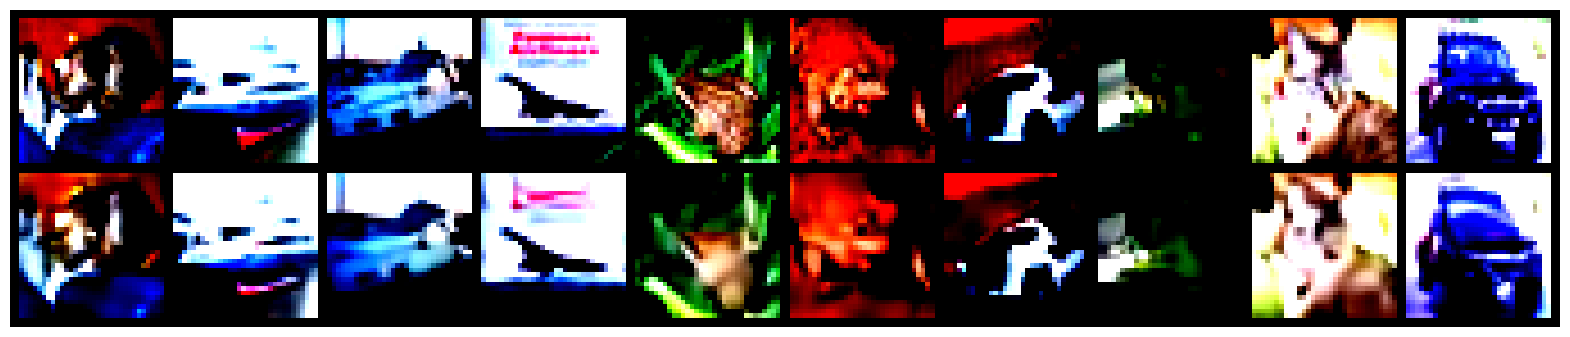

: 

In [33]:
import torchvision
import matplotlib.pyplot as plt

def plot_recons(images, reshape):
    plt.figure(figsize=(20, 6))
    images = torch.Tensor(images).reshape(reshape)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=False, range=(-1,1), )

    grid = grid.permute(1, 2, 0)
    grid = grid.cpu().detach().numpy()

    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    # plt.savefig("../img/mnist_cnn_ae")

images = torch.cat((input_imgs, reconst_imgs), 0)
plot_recons(images=images, reshape=(-1, 3, 32, 32))

In [23]:
torch.randn((1, 32))

tensor([[-0.0183, -0.0710,  1.0175,  0.2821, -0.3796,  0.1737,  0.0508, -0.6747,
          0.0053,  0.7799, -0.1934, -1.2524, -2.2949, -0.0243, -0.6243, -0.7311,
         -1.2963, -1.0389, -0.8930, -0.4966,  1.3816, -0.5419,  0.8535,  1.6367,
         -1.3349, -0.7395,  0.0614,  0.9123,  0.2748, -1.1423,  0.6432, -1.6808]])